## Imports

In [10]:
import os

import pandas as pd
import geopandas as gpd
import numpy as np
import geopy.distance
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.express as px # type: ignore

from datetime import date, timedelta
from tqdm.auto import tqdm

tqdm.pandas()

In [11]:
df = pd.read_parquet('Merges/PETERSON_FINAL.parquet').sort_values(by='datetime').reset_index(drop=True)
df.datetime = pd.to_datetime(df.datetime)

## Heatmap: [Metric] by water year vs distance from South Bay

In [30]:
metric = 'water_temp'

df1 = df.copy()
df1 = df1[df1.chlor.between(0, 15)]

#df1.datetime = df1.datetime + pd.DateOffset(months=-9)

if metric == 'water_temp':
    df1.water_temp = df1.water_temp.combine_first(df1.bow_temp)
    df1 = df1[df1.datetime.dt.date < date(year=2020, month=1, day=1)]

df1.set_index('datetime', inplace=True)

df1.d_from_start = df1.d_from_start.round(0)
grouped = df1.groupby([pd.Grouper(key='d_from_start'), pd.Grouper('datetime', freq='YE')])
result = grouped[metric].mean()
pivot = result.reset_index().pivot_table(index='d_from_start', columns='datetime', values=metric)
pivot = pivot.sort_values(by='d_from_start', ascending=False)

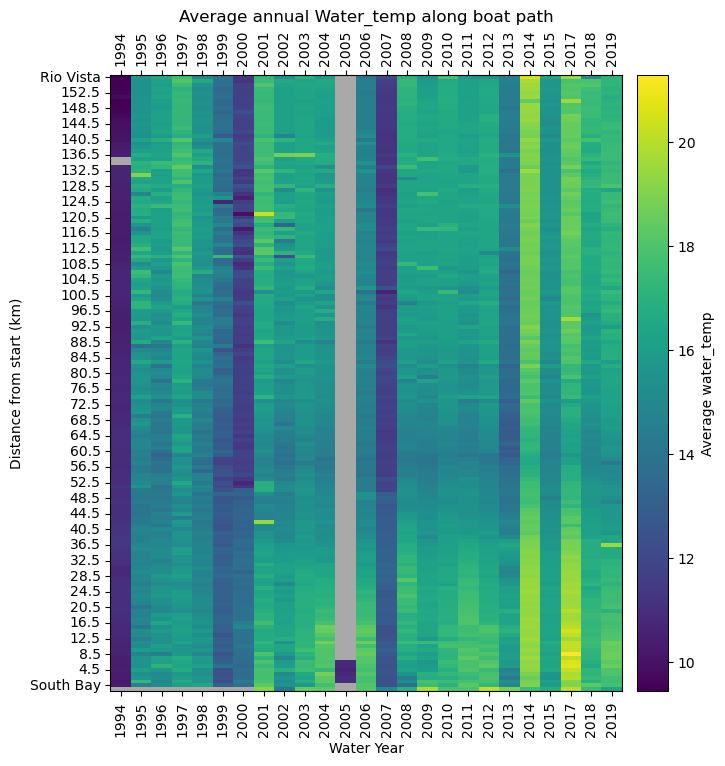

In [31]:
fig = plt.figure(figsize=(8, 8))
plt.title(f'Average annual {metric.capitalize()} along boat path')
ax = sns.heatmap(pivot, cmap='viridis', cbar_kws={'label': f'Average {metric}', 'pad': 0.025})

cbar = ax.collections[0].colorbar
cbar.outline.set_color('black')
cbar.outline.set_linewidth(0.75)

x_tick_labels = [label.get_text()[:4] for label in ax.get_xticklabels()]

ax.set_xticklabels(x_tick_labels)
ax.set_xlabel('Calendar Year')
ax.tick_params(axis='x', top=True, bottom=True, labeltop=True, labelbottom=True, rotation=90)

yticks = ax.get_yticks()
ytick_labels = [f'Rio Vista'] + [str(ytick) for ytick in yticks[1:-1][::-1]] + [f'South Bay']
ax.set_yticklabels(ytick_labels)
ax.set_ylabel('Distance from start (km)')

ax.patch.set_facecolor('darkgrey')
ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(True)
plt.show()

## Heatmap: [Metric] by month vs distance from South Bay

In [28]:
metric = 'water_temp'

df2 = df.copy()
df2 = df2[df2.chlor.between(0, 15)]
#df2.datetime = df2.datetime + pd.DateOffset(months=-9)

if metric == 'water_temp':
    df2.water_temp = df2.water_temp.combine_first(df2.bow_temp)
    df2 = df2[df2.datetime.dt.date < date(year=2020, month=1, day=1)]

df2.set_index('datetime', inplace=True)

df2.d_from_start = df2.d_from_start.round(0)
grouped = df2.groupby([pd.Grouper(key='d_from_start'), pd.Grouper('datetime', freq='ME')])
result = grouped[metric].mean()
pivot2 = result.reset_index().pivot_table(index='d_from_start', columns='datetime', values=metric)
pivot2 = pivot2.T.reset_index(level=['datetime']).reset_index()
pivot2 = (pivot2.groupby(pivot2.datetime.dt.month)
         .mean()
         .drop(columns=['index', 'datetime']).T
         .sort_values(by='d_from_start', ascending=False))

#print(pivot2.head(24))

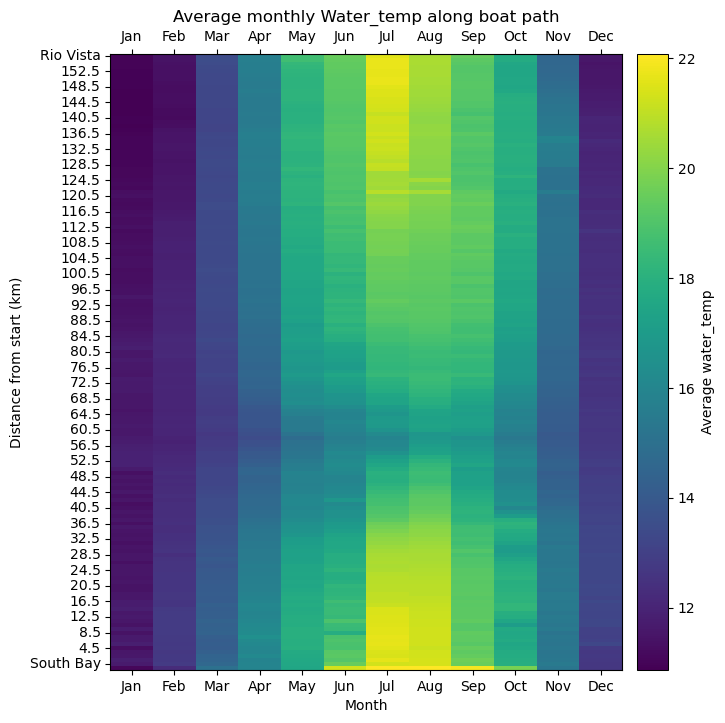

In [29]:
fig = plt.figure(figsize=(8, 8))
plt.title(f'Average monthly {metric.capitalize()} along boat path')
ax = sns.heatmap(pivot2, cmap='viridis', cbar_kws={'label': f'Average {metric}', 'pad': 0.025})

cbar = ax.collections[0].colorbar
cbar.outline.set_color('black')
cbar.outline.set_linewidth(0.75)

ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_xlabel('Month')
ax.tick_params(axis='x', top=True, bottom=True, labeltop=True, labelbottom=True, rotation=0)

yticks = ax.get_yticks()
ytick_labels = [f'Rio Vista'] + [str(ytick) for ytick in yticks[1:-1][::-1]] + [f'South Bay']
ax.set_yticklabels(ytick_labels)
ax.set_ylabel('Distance from start (km)')

ax.patch.set_facecolor('darkgrey')
ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(True)
plt.show()

## Scatterplot: [Metric] over distance

In [6]:
df3 = df.copy().sample(n=50000, random_state=123)
df3 = df3[df3.chlor.between(0, 100)]
df3 = df3.sort_values(by='chlor', ascending=True)

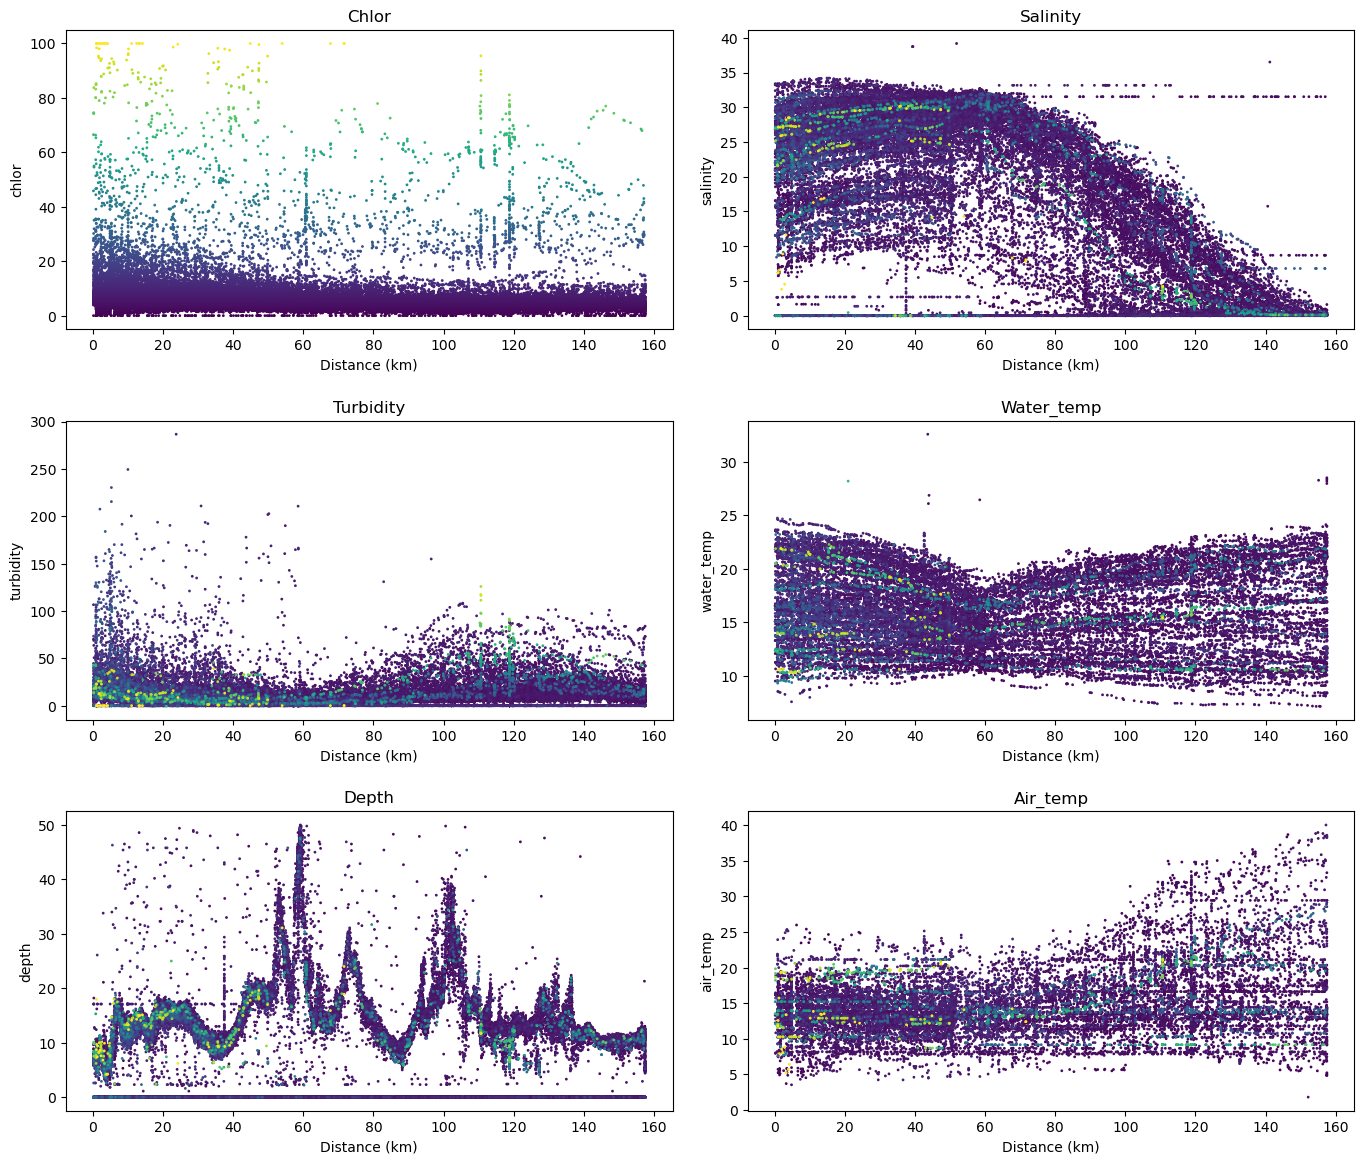

In [7]:
fig, ax = plt.subplots(3, 2, figsize=(14, 12))
ax = np.array(ax).flatten()
metrics = ['chlor', 'salinity', 'turbidity', 'water_temp', 'depth', 'air_temp']

for i, metric in enumerate(metrics):
    # Z-score outlier filtering
    '''roll = df3[metric].rolling(window=50, min_periods=1, center=True)
    avg = roll.mean()
    std = roll.std(ddof=0)
    z = df3[metric].sub(avg).div(std)
    m = z.between(-1, 1)
    df3[metric] = df3[metric].where(m, avg)'''

    df3.plot(ax=ax[i], x='d_from_start', y=metric, kind='scatter', color=df3.chlor, s=1)
    ax[i].set_title(f'{metric.capitalize()}')
    ax[i].set_xlabel('Distance (km)')


fig.tight_layout(pad=2.0)
plt.show()